<ul>
    <li>import required libraries</li>
    <li>import required modules</li>
    <li>import dataset</li>
    <li>take care of missing values</li>
    <li>apply EDA on the dataset</li>
    <li>take care of categorical and continuous columns and divide them in training and validation set</li>
    <li>Linear Regression</li>
        <ul><li>finding out collinerity</li></ul>
    <li>Polynomial Regression</li>
    <li>Random Forest</li>
        <ul>
        <li>Removing Collinearity using clustering and dendo graph</li>
        <li>Hyperparameter tuning of the model</li>
        <li>plot of RMSE on train and validation data</li>
        <li>Reducing OVERFITTING</li>
        </ul>
    <li>Find out more plots</li>
    <li>Interpret the model and result using treeinterpretor and waterfall diagram</li>
    <li>upload on GitHub</li>
</ul>

## Importing Libraries

In [76]:
import fastai
from fastai import *
from fastai.tabular.all import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error

### Defining some functions

In [77]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, x, y): return r_mse(m.predict(x), y)

## Importing Dataset

In [78]:
path="C:/Users/1042g/Desktop/ML foundation  CA2/data/machine data.csv"
df_raw=pd.read_csv(path,header=None,low_memory=False)
df_raw.columns=["vendor name","Model Name","MYCT","MMIN","MMAX","CACH","CHMIN",
                                 "CHMAX","PRP","ERP"]
df_original=df_raw.copy()
df_raw

,vendor name,Model Name,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
0,adviser,32/60,125,256,6000,256,16,128,198,199
1,amdahl,470v/7,29,8000,32000,32,8,32,269,253
2,amdahl,470v/7a,29,8000,32000,32,8,32,220,253
3,amdahl,470v/7b,29,8000,32000,32,8,32,172,253
4,amdahl,470v/7c,29,8000,16000,32,8,16,132,132
...,...,...,...,...,...,...,...,...,...,...
204,sperry,80/8,124,1000,8000,0,1,8,42,37
205,sperry,90/80-model-3,98,1000,8000,32,2,8,46,50
206,sratus,32,125,2000,8000,0,2,14,52,41
207,wang,vs-100,480,512,8000,32,0,0,67,47


## Taking care of missing values

In [79]:
df_raw.isna().sum()

vendor name    0
Model Name     0
MYCT           0
MMIN           0
MMAX           0
CACH           0
CHMIN          0
CHMAX          0
PRP            0
ERP            0
dtype: int64

## Original Dataset prediction performance

In [80]:
print("RMSE of original prediction: ",r_mse(df_original["PRP"],df_original["ERP"]))
print("R2 Score of original prediction: ",r2_score(df_original["PRP"],df_original["ERP"]))

RMSE of original prediction:  41.68135
R2 Score of original prediction:  0.9325117107972016


### Dropping the ERP column of the dataset

In [81]:
df_raw.drop(["ERP"],axis=1,inplace=True)

## Divinding the data into train and validation set

<AxesSubplot:>

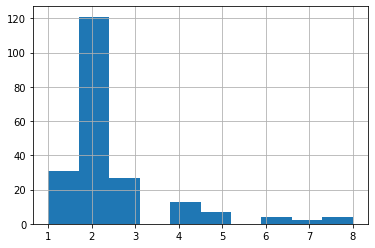

In [82]:
df_raw["PRP_cat"]=pd.cut(df_raw["PRP"],
                     bins=[0., 20.,100., 200., 300.,400.,500.,600., np.inf],labels=[1, 2, 3, 4, 5,6,7,8])
df_raw["PRP_cat"].hist()

In [83]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, valid_index in split.split(df_raw, df_raw["PRP_cat"]):
 strat_train_set = df_raw.loc[train_index]
 strat_valid_set = df_raw.loc[valid_index]

<AxesSubplot:>

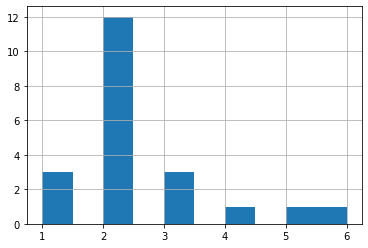

In [84]:
strat_valid_set["PRP_cat"].hist()

In [85]:
splits = (list(train_index),list(valid_index))

In [86]:
df_raw.drop(["PRP_cat"],axis=1,inplace=True)

### Taking care of categorical value and dividing them into dependent variables and target variable

In [87]:
dep_var="PRP"
procs = [Categorify, FillMissing]
cont,cat = cont_cat_split(df_raw, 1, dep_var=dep_var)
df=TabularPandas(df_raw, procs, cat, cont, y_names=dep_var,splits=splits)

In [88]:
X_train,y_train = df.train.xs,df.train.y
X_valid,y_valid = df.valid.xs,df.valid.y

## Building Random Forest with Sklearn

In [89]:
from sklearn.ensemble import RandomForestRegressor
m=RandomForestRegressor(n_estimators=200,oob_score=True)
m.fit(X_train,y_train)
print(m_rmse(m,X_train,y_train))
print(m.oob_score_)
predict=m.predict(X_train)
print(r2_score(y_train,predict))
print("ON THE VALIDATION DATA")
print(m_rmse(m,X_valid,y_valid))
print(r2_score(y_valid,m.predict(X_valid)))


21.153866
0.8691921374959266
0.9833774661137734
ON THE VALIDATION DATA
35.248802
0.9181798294228551


## Using GridSearch to find best HyperParameter

In [90]:
from sklearn.model_selection import GridSearchCV

In [91]:
m=RandomForestRegressor()
param_grid = [
 {'n_estimators': [50,100,200], 'max_features': [None,0.5,2, 4],
  "max_leaf_nodes":[None,10,11],"max_depth":[None,10,8]},]
grid_search = GridSearchCV(m, param_grid,scoring='neg_root_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid=[{'max_depth': [None, 10, 8],
                          'max_features': [None, 0.5, 2, 4],
                          'max_leaf_nodes': [None, 10, 11],
                          'n_estimators': [50, 100, 200]}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [100]:
grid_search.best_params_

{'max_depth': 10,
 'max_features': 4,
 'max_leaf_nodes': None,
 'n_estimators': 50}

In [93]:
#grid_search.cv_results_

In [101]:
m=grid_search.best_estimator_

In [102]:
m

RandomForestRegressor(max_depth=10, max_features=4, n_estimators=50)

In [103]:
#m=grid_search.best_params_
m.fit(X_train,y_train)
print("RMSE of training data",m_rmse(m,X_train,y_train))
#print(m.oob_score_)
predict=m.predict(X_train)
print("R2 Score of training data",r2_score(y_train,predict))
print("ON THE VALIDATION DATA")
print("RMSE of validation data",m_rmse(m,X_valid,y_valid))
print("R2 Score of validation data",r2_score(y_valid,m.predict(X_valid)))

RMSE of training data 25.44782
R2 Score of training data 0.9759442488038268
ON THE VALIDATION DATA
RMSE of validation data 33.478965
R2 Score of validation data 0.9261899164404589


In [104]:
from sklearn.metrics import mean_squared_error

In [105]:
def plot_learning_curves(model, X_train, y_train,X_valid,y_valid):
 train_errors, val_errors = [], []
 for m in range(1, len(X_train)):
     model.fit(X_train[:m], y_train[:m])
     y_train_predict = model.predict(X_train[:m])
     y_val_predict = model.predict(X_valid)
     train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
     val_errors.append(mean_squared_error(y_valid, y_val_predict))
     plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
     plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
     plt.ylim(0,100)


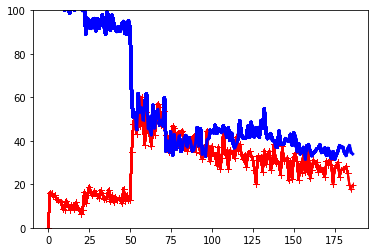

In [106]:
plot_learning_curves(m,X_train,y_train,X_valid,y_valid)
plt.savefig("Random Forest learning curve")

In [ ]:
import sklearn
sklearn.metrics.SCORERS.keys()

In [107]:
def rf_feat_importance(m, df):
 return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
 ).sort_values('imp', ascending=False)

In [108]:
fi = rf_feat_importance(m, X_train)
fi[:10]

,cols,imp
4,MMAX,0.467747
5,CACH,0.160235
6,CHMIN,0.122052
3,MMIN,0.103861
7,CHMAX,0.076333
2,MYCT,0.043170
1,Model Name,0.020745
0,vendor name,0.005857


In [109]:
def plot_fi(fi):
    return fi.plot('cols','imp','barh',figsize=(12,7),legend=False)

<AxesSubplot:ylabel='cols'>

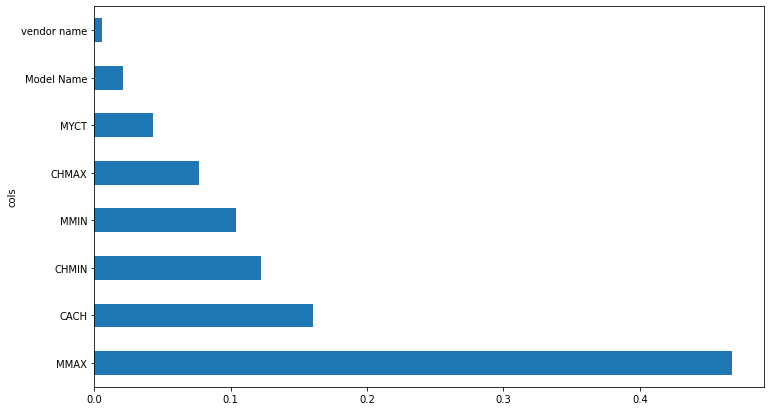

In [110]:
plot_fi(fi)

In [111]:
from scipy.cluster import hierarchy as hc

def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.savefig("Dendograph of collierity1")
    plt.show()

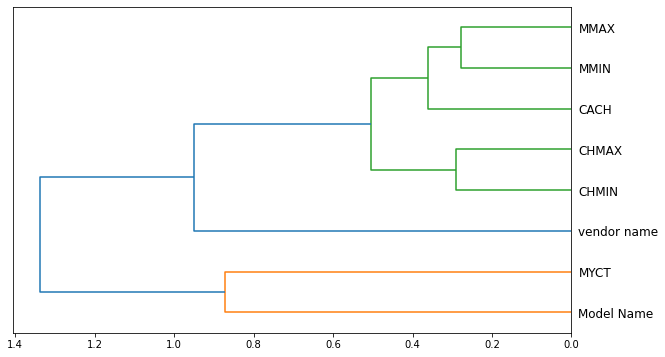

In [112]:
cluster_columns(X_train)

In [113]:
corr_matrix = X_train.corr()

In [114]:
corr_matrix

,vendor name,Model Name,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX
vendor name,1.000000,-0.110366,-0.088209,-0.056686,0.027265,0.013022,0.058799,0.000637
Model Name,-0.110366,1.000000,0.070300,-0.129939,-0.199887,-0.047911,-0.231665,-0.161569
MYCT,-0.088209,0.070300,1.000000,-0.345468,-0.373767,-0.321879,-0.300483,-0.253041
MMIN,-0.056686,-0.129939,-0.345468,1.000000,0.750557,0.529260,0.501154,0.265147
MMAX,0.027265,-0.199887,-0.373767,0.750557,1.000000,0.522083,0.550775,0.544452
CACH,0.013022,-0.047911,-0.321879,0.529260,0.522083,1.000000,0.575333,0.496217
CHMIN,0.058799,-0.231665,-0.300483,0.501154,0.550775,0.575333,1.000000,0.552911
CHMAX,0.000637,-0.161569,-0.253041,0.265147,0.544452,0.496217,0.552911,1.000000


In [115]:
def get_oob(df):
    m1=RandomForestRegressor(max_depth=10, max_features=4, n_estimators=50,oob_score=True)    
    m1.fit(df, y_train)
    return m1.oob_score_


In [116]:
get_oob(X_train)

0.8572460976923185

In [117]:
{c:get_oob(X_train.drop(c, axis=1)) for c in ('MMIN', 'MMAX','CHMIN','CHMAX')}

{'MMIN': 0.8880335992921655,
 'MMAX': 0.8370930704007347,
 'CHMIN': 0.8524091526606918,
 'CHMAX': 0.8421736319623147}

In [118]:
to_drop = ['MMIN','CHMAX']
get_oob(X_train.drop(to_drop, axis=1))

0.8766197470648261

In [119]:
X_train_final = X_train.drop(to_drop, axis=1)
X_valid_final = X_valid.drop(to_drop, axis=1)

In [120]:
#m=RandomForestRegressor(n_estimators=300,oob_score=True)
m.fit(X_train_final,y_train)
print(m_rmse(m,X_train_final,y_train))
#print(m.oob_score_)
predict=m.predict(X_train_final)
print(r2_score(y_train,predict))
print("ON THE VALIDATION DATA")
print(m_rmse(m,X_valid_final,y_valid))
print(r2_score(y_valid,m.predict(X_valid_final)))                      

21.634537
0.9826134690391721
ON THE VALIDATION DATA
38.075681
0.9045299828123381


In [ ]:
plot_learning_curves(m,X_train,y_train,X_valid,y_valid)
plt.savefig("Random Forest learning curve")

In [121]:
m1=RandomForestRegressor()
param_grid = [
 {'n_estimators': [50,100,200,300], 'max_features': [None,0.5,2, 4],
  "max_leaf_nodes":[None,10,11],"max_depth":[None,10,12,15]},]
grid_search = GridSearchCV(m1, param_grid,scoring='neg_root_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train_final,y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid=[{'max_depth': [None, 10, 12, 15],
                          'max_features': [None, 0.5, 2, 4],
                          'max_leaf_nodes': [None, 10, 11],
                          'n_estimators': [50, 100, 200, 300]}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [122]:
grid_search.best_params_

{'max_depth': 10,
 'max_features': 0.5,
 'max_leaf_nodes': None,
 'n_estimators': 200}

In [123]:
m1=grid_search.best_estimator_

In [124]:
#m=RandomForestRegressor(n_estimators=300,oob_score=True)
m1.fit(X_train_final,y_train)
print(m_rmse(m1,X_train_final,y_train))
#print(m.oob_score_)
predict=m1.predict(X_train_final)
print(r2_score(y_train,predict))
print("ON THE VALIDATION DATA")
print(m_rmse(m1,X_valid_final,y_valid))
print(r2_score(y_valid,m1.predict(X_valid_final)))


21.555709
0.982739936942699
ON THE VALIDATION DATA
37.10718
0.9093250046983375


In [125]:
dep_var="PRP"
procs = [Categorify, FillMissing]
cont,cat = cont_cat_split(df_raw, 1, dep_var=dep_var)
df_full=TabularPandas(df_raw, procs, cat, cont, y_names=dep_var)

In [126]:
df_full.train.xs.shape,df_full.train.y.shape

((209, 8), (209,))

In [127]:
X_train,y_train=df_full.train.xs,df_full.train.y
X_train = X_train.drop(to_drop, axis=1)

## Making Random Forest model imported from sklearn

In [128]:
from sklearn.ensemble import RandomForestRegressor
#m=RandomForestRegressor(n_estimators=300,oob_score=True)
m1.fit(X_train,y_train)
print(m_rmse(m1,X_train,y_train))
predict=m1.predict(X_train)
print(r2_score(y_train,predict))

22.120469
0.980992126658771


## Import tree Interpretor and Waterfall library

In [129]:
!pip install treeinterpreter
!pip install waterfallcharts
import treeinterpreter
import waterfall_chart

In [130]:
row = X_valid_final.iloc[:5]

In [131]:
from treeinterpreter import treeinterpreter as ti

In [136]:
prediction, bias, contributions = ti.predict(m, row.values)

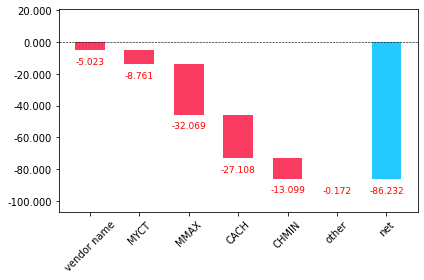

In [138]:
waterfall_chart.plot(X_valid_final.columns, contributions[0], threshold=0.08,
 rotation_value=45,formatting='{:,.3f}');
plt.savefig("waterfall chart")